In [1]:
from transformers import YolosImageProcessor, YolosForObjectDetection
from PIL import Image
import torch
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

model = YolosForObjectDetection.from_pretrained('hustvl/yolos-tiny')
image_processor = YolosImageProcessor.from_pretrained("hustvl/yolos-tiny")

inputs = image_processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# model predicts bounding boxes and corresponding COCO classes
logits = outputs.logits
bboxes = outputs.pred_boxes

# print results
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/26.0M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

Detected remote with confidence 0.991 at location [46.48, 72.78, 178.98, 119.3]
Detected remote with confidence 0.908 at location [336.48, 79.27, 368.23, 192.36]
Detected cat with confidence 0.934 at location [337.18, 18.06, 638.14, 373.09]
Detected cat with confidence 0.979 at location [10.93, 53.74, 313.41, 470.67]
Detected remote with confidence 0.974 at location [41.63, 72.23, 178.09, 119.99]


In [ ]:
results

{'scores': tensor([0.9910, 0.9085, 0.9336, 0.9794, 0.9740], grad_fn=<IndexBackward0>),
 'labels': tensor([75, 75, 17, 17, 75]),
 'boxes': tensor([[ 46.4760,  72.7763, 178.9760, 119.3046],
         [336.4786,  79.2662, 368.2279, 192.3569],
         [337.1848,  18.0634, 638.1445, 373.0924],
         [ 10.9292,  53.7410, 313.4107, 470.6720],
         [ 41.6319,  72.2281, 178.0870, 119.9883]], grad_fn=<IndexBackward0>)}

In [ ]:
results["boxes"]

tensor([[ 46.4760,  72.7763, 178.9760, 119.3046],
        [336.4786,  79.2662, 368.2279, 192.3569],
        [337.1848,  18.0634, 638.1445, 373.0924],
        [ 10.9292,  53.7410, 313.4107, 470.6720],
        [ 41.6319,  72.2281, 178.0870, 119.9883]], grad_fn=<IndexBackward0>)

[46, 72, 178, 119]
[336, 79, 368, 192]
[337, 18, 638, 373]
[10, 53, 313, 470]
[41, 72, 178, 119]


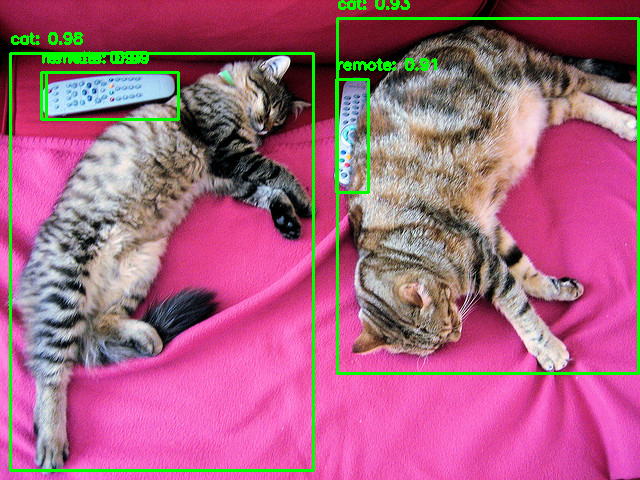

In [ ]:
import cv2
import numpy as np
opencv_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [int(i) for i in box.tolist()]
    cv2.rectangle(opencv_image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
    label = f'{model.config.id2label[label.item()]}: {round(score.item(), 3):.2f}'
    cv2.putText(opencv_image, label, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
from google.colab.patches import cv2_imshow
cv2_imshow(opencv_image)

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.9/906.9 kB 23.8 MB/s eta 0:00:00


In [ ]:
!pip show ultralytics

Name: ultralytics
Version: 8.3.61
Summary: Ultralytics YOLO 🚀 for SOTA object detection, multi-object tracking, instance segmentation, pose estimation and image classification.
Home-page: https://ultralytics.com
Author: 
Author-email: Glenn Jocher <glenn.jocher@ultralytics.com>, Jing Qiu <jing.qiu@ultralytics.com>
License: AGPL-3.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: matplotlib, numpy, opencv-python, pandas, pillow, psutil, py-cpuinfo, pyyaml, requests, scipy, seaborn, torch, torchvision, tqdm, ultralytics-thop
Required-by: 


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.35M/5.35M [00:00<00:00, 47.3MB/s]



0: 480x640 2 cats, 1 couch, 1 remote, 1071.9ms
Speed: 13.4ms preprocess, 1071.9ms inference, 38.1ms postprocess per image at shape (1, 3, 480, 640)


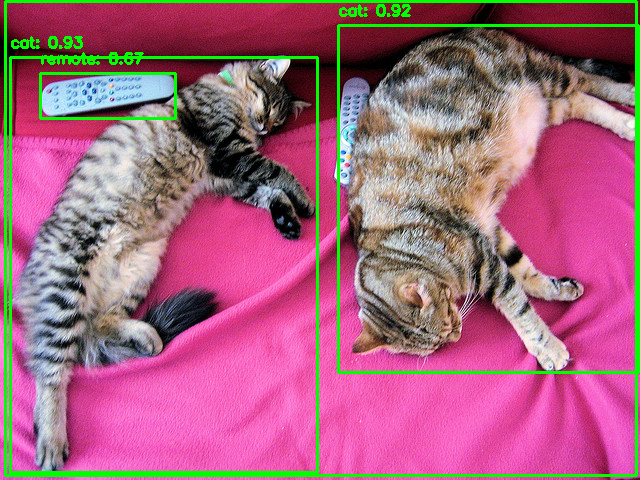

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
from ultralytics import YOLO
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = YOLO("yolo11n.pt").to(device)

img = cv2.imread('/content/000000039769.jpg')
results = model(img)

for result in results:
    boxes = result.boxes.xyxy.cpu().numpy().astype('uint32')
    classes = result.boxes.cls.cpu().numpy().astype('int')
    confidences = result.boxes.conf.cpu().numpy()

    for box, cls, conf in zip(boxes, classes, confidences):
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
        label = f'{model.names[cls]}: {conf:.2f}'
        cv2.putText(img, label, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
cv2_imshow(img)

In [ ]:
source = 'http://images.cocodataset.org/val2017/000000039769.jpg'
model.predict(source=source, save=True)


Found http://images.cocodataset.org/val2017/000000039769.jpg locally at 000000039769.jpg
image 1/1 /content/000000039769.jpg: 480x640 2 cats, 1 couch, 1 remote, 620.3ms
Speed: 6.8ms preprocess, 620.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p